In [96]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.decomposition import PCA
%matplotlib inline

In [97]:


df = pd.read_csv("bear_attacks.csv" )



df.Date = pd.to_datetime(df.Date , format = 'mixed' , errors='coerce')
df['month'] = pd.Categorical(df.Date.dt.month.astype('Int64') ,categories = list(range(1 , 13)) )
df['Gender'] = pd.Categorical(df['Gender'])


def is_fatal(details):

    fatal_keywords = [
    'died', 'killed', 'fatal', 'dead', 'mauled to death', 'succumbed',
    'did not survive', 'passed away', 'pronounced dead', 'lost his life',
    'lost her life', 'slain', 'fatally injured', 'mortally wounded'
    ]
    return any(keyword in details.lower() for keyword in fatal_keywords)


df['Fatal'] = df['Details'].apply(is_fatal).astype(int)

states = [
    'Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO',
    'Connecticut', 'CT', 'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 
    'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 
    'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 
    'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 
    'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 
    'Oklahoma', 'OK', 'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 
    'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 
    'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY'
]



def extract_state_from_split(location):
    
    location_parts = [part.strip() for part in location.split(',')]
    
    
    for part in location_parts:
        if part in states:
            return part
    return None


df['State'] = df['Location'].apply(extract_state_from_split)
df.loc[df['State'].isna() , "State"] = "Unknown"

def convert_age(age):
    if pd.isna(age) or age == '':  # Handle NaN
        return math.nan
    if isinstance(age, str):
        age = age.strip()  # Remove leading/trailing whitespace
        # Handle months
        if 'months' in age:
            months = int(age.split()[0])
            return months / 12
            
        # Remove non-numeric characters like quotes, and try converting to float
        age = ''.join(filter(str.isdigit, age))
        if age:
            return float(age)
    return age # If it's already a number, return it as is

# Reapply the function to clean and convert the 'Age' column
df['Age'] = df['Age'].apply(convert_age)

# Checking the unique values in the Age column to ensure the conversion was successful
df.loc[df['Age'] == "" , 'Age'] = np.nan
df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,month,Fatal,State
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33.0,male,8,1,Unknown
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31.0,male,7,1,Unknown
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64.0,female,7,0,Unknown
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28.0,male,12,1,Alaska
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46.0,male,11,0,Unknown


In [98]:
data = df[['Age' , 'Latitude' , 'Longitude' , 'month' ,'Fatal']].dropna()

X = data[[ 'Longitude' , 'Latitude' , 'Age' , 'month']]
y = data['Fatal']
X_train , X_test , y_train , y_test = train_test_split(X , y, train_size=0.80  , random_state= 42 )



pca = PCA(n_components = 'mle')
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train) , columns=['PC1' , "PC2" , "PC3"])
print(f"X dimensions: {X_train.shape}")
print(pca.explained_variance_ratio_)

X dimensions: (118, 3)
[0.55822748 0.38469369 0.05201324]


In [99]:
X_train.head()

,PC1,PC2,PC3
0,3.182168,7.151570,-5.566002
1,-6.837474,2.432838,6.318883
2,9.528500,-13.932669,-6.256434
3,-4.500116,55.341068,-11.259935
4,15.356174,11.427827,11.772081


In [100]:
data = pd.concat([X_train , y_train.astype('int')] , axis = 1)
import plotly.graph_objects as go

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=data['PC1'],  # X axis
    y=data['PC2'],  # Y axis
    z=data['PC3'],  # Z axis
    mode='markers',
    marker=dict(
        size=5,
        color=data['Fatal'],  # Set color to 'Fatal' column
        colorscale='Viridis',  # Color scale
        colorbar=dict(title='Fatal'),  # Color bar label
    )
)])

# Update the layout to add axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title="Interactive 3D Scatter Plot",
)

# Show the interactive plot
fig.show()

In [101]:
import random
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'C' : [random.uniform(0.01, 1.0) for _ in range(100)],
    'solver' : [ 'liblinear' , 'saga'],
    'penalty' : ['l1', 'l2' ]
}


base_model = LogisticRegression(random_state= 42 , max_iter= 10000)
gs = GridSearchCV(base_model , hyperparameters , verbose=False , cv = 5)
gs.fit(X_train , np.ravel(y_train))


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.6474171369288088, 0.4596839454632913,
                               0.33696156187353743, 0.9531310884889255,
                               0.27057894999200566, 0.8823223876233951,
                               0.5769826299757885, 0.4280534234129925,
                               0.607855751761208, 0.843711016029062,
                               0.6844049144765344, 0.853058284928222,
                               0.8895973221582547, 0.026181...
                               0.8271561369242209, 0.7453762663007771,
                               0.0645986825603304, 0.048389840476123484,
                               0.6902336962569718, 0.7690526668774559,
                               0.6803630900048159, 0.4500388244528739,
                               0.29334194449290757, 0.6450394386529117,
                               0.32041313189144044, 0.4986943571291623,
                               0.34733192362286636, 0.3015771334938669,
                               0.040269896174388586, 0.5906757148146479, ...],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=False)

In [102]:
from sklearn.metrics import RocCurveDisplay
logit = gs.best_estimator_
y_train_pred = logit.predict(X_train)
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train , y_train_pred , normalize='true' )

In [103]:
pd.DataFrame(y_train_pred).value_counts()/len(y_train_pred)

0
1    0.974576
0    0.025424
Name: count, dtype: float64

In [104]:
y_train.value_counts()/len(y_train)

Fatal
1    0.745763
0    0.254237
Name: count, dtype: float64

True positive rate: 0.99
False positive rate: 0.93
True negative rate: 0.01
False Negative rate: 0.07


<Figure size 640x480 with 0 Axes>

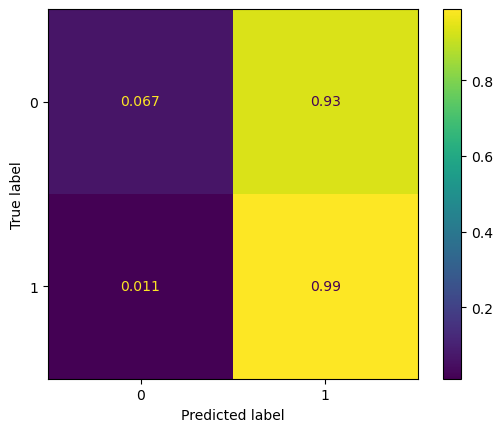

In [105]:
plt.clf()
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

conf_m = confusion_matrix(y_train , y_train_pred ,     normalize='true')
tp , fp , tn , fn = conf_m[1,1] , conf_m[0,1] , conf_m[1,0] , conf_m[0,0]
print(f"True positive rate: {tp:.2f}")
print(f"False positive rate: {fp:.2f}")
print(f"True negative rate: {tn:.2f}")
print(f"False Negative rate: {fn:.2f}")

ConfusionMatrixDisplay.from_predictions(y_train , y_train_pred , normalize='true' )
plt.show()

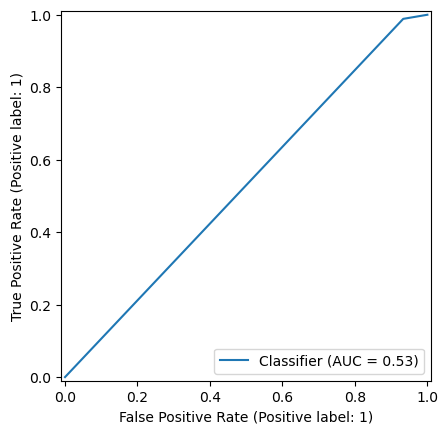

In [114]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [107]:
X_test = pd.DataFrame(pca.transform(X_test) , columns = ['PC1' , "PC2" , "PC3"])
logit.score(X_test , y_test)

0.8333333333333334